## In this notebook we are going to try to classify the tweets in subcategories

The categories are going to be described below

In [84]:
import os

os.getcwd()

'/Users/fserra/BSC/cuentalo/cuentalo/notebooks'

In [85]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

#### We need to use padding to set all sentences to the same length

In [86]:
# word_to_index = dictionary_of_words mapped to their index 

In [87]:
import json
with open('dict_of_words.json') as json_data:
    dict_of_words = json.load(json_data)

In [88]:
word_to_index = {k: v for v, k in enumerate(list(dict_of_words.keys()))}

In [89]:
word_to_index['UNK'] = len(word_to_index) + 1

In [90]:
def sentences_to_indices(X, word_to_index, max_len):
    '''
    '''
    m = X.shape[0]
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):
        sentence_words = [word.lower() for word in X[i].split()]
        j=0
        for w in sentence_words:
            if w in list(word_to_index.keys()):
                X_indices[i, j] = word_to_index[w]
            else:
                X_indices[i, j] = word_to_index['UNK']
            j+=1
    
    return X_indices

In [91]:
sentence_1 = np.array(['me cago en la puta de oros', 'hola', 'kajsdajk'])
indices_1 = sentences_to_indices(sentence_1, word_to_index, 20)

In [92]:
indices_1

array([[  1092.,   4097.,  10274., 165613.,   1268.,   1736., 165613.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.],
       [  3366.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.],
       [165613.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.]])

In [93]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    '''
    '''
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map['hola'].shape[0]
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
    
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [94]:
from pandas import read_pickle

df = read_pickle('../data/cuentalo_json_con_pais_ciudad_limpios.pkl')
df.sample(5)

df.describe()

,favorite_count,id,lat,lon,parent_favorite_count,parent_id,parent_lat,parent_lon,parent_quote_count,parent_retweet_count,parent_user_followers_count,parent_user_id,parent_user_statuses_count,quote_count,retweet_count,user_followers_count,user_id,user_statuses_count,location_diagnosis,parent_location_diagnosis
count,2.111998e+06,2.111998e+06,2.111998e+06,2.111998e+06,2.111998e+06,2.111998e+06,2.111998e+06,2.111998e+06,2111998.0,2.111998e+06,2.111998e+06,2.111998e+06,2.111998e+06,2111998.0,2.111998e+06,2.111998e+06,2.111998e+06,2.111998e+06,2.111998e+06,2.000661e+06
mean,2.029157e+00,9.910709e+17,-1.016308e+03,-1.016308e+03,1.202064e+04,9.385780e+17,-1.016302e+03,-1.016302e+03,-1.0,6.586915e+03,2.151193e+04,1.803327e+17,2.386319e+04,-1.0,6.575469e+03,1.190780e+03,1.990208e+17,2.445627e+04,3.996142e+00,4.323881e+00
std,1.513535e+02,6.537200e+14,1.750235e+01,1.753262e+01,1.673897e+04,2.214261e+17,1.764728e+01,1.766846e+01,0.0,1.018583e+04,2.434805e+05,3.496776e+17,4.082015e+04,0.0,1.017846e+04,2.975579e+04,3.652792e+17,4.358996e+04,6.456736e+00,6.407519e+00
min,0.000000e+00,9.896707e+17,-9.990000e+02,-9.990000e+02,-1.000000e+00,0.000000e+00,-9.990000e+02,-9.990000e+02,-1.0,-1.000000e+00,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.0,0.000000e+00,0.000000e+00,2.654000e+03,1.000000e+00,-7.000000e+00,-7.000000e+00
25%,0.000000e+00,9.907925e+17,-9.990000e+02,-9.990000e+02,4.990000e+02,9.904601e+17,-9.990000e+02,-9.990000e+02,-1.0,2.540000e+02,3.370000e+02,2.892574e+08,2.082000e+03,-1.0,2.490000e+02,1.830000e+02,4.554929e+08,4.026000e+03,-1.000000e+00,-1.000000e+00
50%,0.000000e+00,9.910289e+17,-9.990000e+02,-9.990000e+02,4.873000e+03,9.907799e+17,-9.990000e+02,-9.990000e+02,-1.0,2.618500e+03,8.080000e+02,1.358220e+09,1.037700e+04,-1.0,2.603000e+03,4.290000e+02,1.647582e+09,1.249300e+04,2.000000e+00,3.000000e+00
75%,0.000000e+00,9.913773e+17,-9.990000e+02,-9.990000e+02,1.575400e+04,9.910347e+17,-9.990000e+02,-9.990000e+02,-1.0,8.166000e+03,2.544000e+03,3.401654e+09,2.771800e+04,-1.0,8.162000e+03,8.750000e+02,4.561256e+09,2.986400e+04,1.200000e+01,1.200000e+01
max,7.179600e+04,9.954528e+17,3.261765e+00,5.068810e+01,5.248730e+05,9.954446e+17,-5.863086e+01,4.609870e+00,-1.0,2.182120e+05,4.201016e+07,9.944996e+17,8.772982e+06,-1.0,5.548200e+04,1.671811e+07,9.953357e+17,8.772982e+06,2.200000e+01,2.200000e+01


In [95]:
df.columns

Index(['country', 'created_at', 'favorite_count', 'full_text', 'id', 'lat',
       'location', 'lon', 'parent_country', 'parent_created_at',
       'parent_favorite_count', 'parent_full_text', 'parent_id', 'parent_lat',
       'parent_location', 'parent_lon', 'parent_place', 'parent_quote_count',
       'parent_retweet_count', 'parent_time_zone', 'parent_user_created_at',
       'parent_user_followers_count', 'parent_user_id', 'parent_user_name',
       'parent_user_screen_name', 'parent_user_statuses_count', 'place',
       'quote_count', 'retweet_count', 'time_zone', 'tweet_type',
       'user_created_at', 'user_followers_count', 'user_id', 'user_name',
       'user_screen_name', 'user_statuses_count', 'ciudad_clean', 'pais_clean',
       'location_diagnosis', 'parent_ciudad_clean', 'parent_pais_clean',
       'parent_location_diagnosis'],
      dtype='object')

In [96]:
df['len'] = df['full_text'].apply(lambda x: len([w for w in x.split(' ')]))

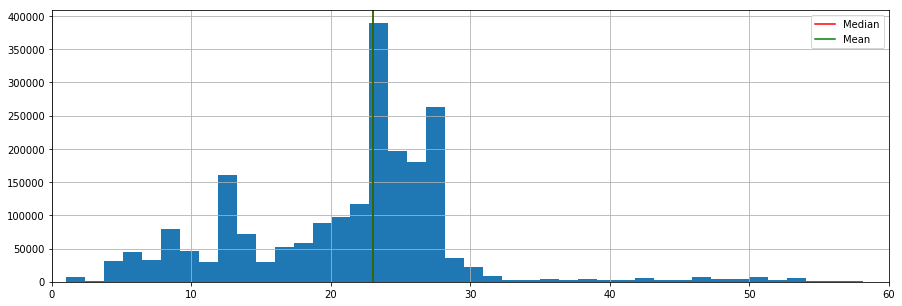

In [97]:
import matplotlib.pyplot as plt

df['len'].hist(bins=100, figsize=(15, 5))

plt.axvline(df['len'].median(), color='r', label='Median')
plt.axvline(df['len'].median(), color='g', label='Mean')
plt.xlim([0, 60])
plt.legend()
plt.show()

In [29]:
from nltk.stem import PorterStemmer

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [7]:
# https://github.com/uchile-nlp/spanish-word-embeddings/blob/master/examples/Ejemplo_WordVectors.ipynb
    
from gensim.models.keyedvectors import KeyedVectors
wordvectors_file_vec = '../data/glove-sbwc.i25.vec'
cantidad = 100000
wordvectors = KeyedVectors.load_word2vec_format(wordvectors_file_vec, limit=cantidad)

In [8]:
wordvectors.most_similar_cosmul(positive=['rey','mujer'],negative=['hombre'])

[('reina', 0.9141066670417786),
 ('isabel', 0.8743278384208679),
 ('princesa', 0.843113124370575),
 ('infanta', 0.8425983190536499),
 ('monarca', 0.8357319831848145),
 ('hija', 0.8211697340011597),
 ('consorte', 0.8179485201835632),
 ('iv', 0.813984215259552),
 ('esposa', 0.8115167617797852),
 ('ii', 0.8099035024642944)]

In [9]:
wordvectors.most_similar_cosmul(positive=['violar'], topn=30)

[('infringir', 0.8262576460838318),
 ('vulnerar', 0.8064225316047668),
 ('abusar', 0.7888485789299011),
 ('violado', 0.7873435020446777),
 ('amenazar', 0.7842590808868408),
 ('incumplir', 0.774122953414917),
 ('atentar', 0.770669162273407),
 ('agredir', 0.7704819440841675),
 ('obstaculizar', 0.770205020904541),
 ('privar', 0.7696232199668884),
 ('violan', 0.7674556970596313),
 ('violación', 0.7638621926307678),
 ('secuestrar', 0.7596122622489929),
 ('acusado', 0.7497574090957642),
 ('libertad', 0.7407402396202087),
 ('pretexto', 0.7400166988372803),
 ('acusa', 0.7390723824501038),
 ('lesionar', 0.7389935255050659),
 ('matar', 0.7385897040367126),
 ('violen', 0.7361158132553101),
 ('violando', 0.7354563474655151),
 ('imponer', 0.7323136925697327),
 ('interferir', 0.7323079705238342),
 ('acusada', 0.7322155237197876),
 ('viola', 0.7317330241203308),
 ('cometer', 0.7317190766334534),
 ('asesinar', 0.7314013242721558),
 ('maltratar', 0.7307785749435425),
 ('robar', 0.7299070358276367),
 ('